<a href="https://colab.research.google.com/github/sdevi49/ML_Python/blob/main/Hybrid_Drug_Recommendation_System_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811606 sha256=e9024ac1bc70843c8079be5b88a3071460186d79b16678b4f8af62ec6ff44eeb
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import nltk
import re
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df=pd.read_csv("/content/drive/My Drive/webmd.csv")
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [ ]:
df.columns

Index(['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse',
       'Effectiveness', 'Reviews', 'Satisfaction', 'Sex', 'Sides',
       'UsefulCount'],
      dtype='object')

In [ ]:
df.shape

(362806, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [ ]:
df.isna().sum()

Age               0
Condition         0
Date              0
Drug              0
DrugId            0
EaseofUse         0
Effectiveness     0
Reviews          37
Satisfaction      0
Sex               0
Sides             0
UsefulCount       0
dtype: int64

In [ ]:
df['Age'] = df['Age'].replace('Unknown', np.nan)

In [ ]:
df=df.dropna()
df.isna().sum()

Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
Sides            0
UsefulCount      0
dtype: int64

In [ ]:
df.duplicated().sum()

943

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Step a: Convert text to lowercase
df['Reviews'] = df['Reviews'].str.lower()
df['Condition'] = df['Condition'].str.lower()

# Step b: Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

# Step c: Remove numbers, punctuation, emojis, and html
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))  # Remove non-alphabetic characters
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub('<.*?>', ' ', x))  # Remove HTML tags

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df.shape

(361826, 12)

In [ ]:
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,stuffy nose,9/21/2014,25dph-7.5peh,146724,5,5,m retired physician meds tried allergies se...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,cold symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared right even throat hurting went away ta...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,ptinr go normal,3,Female,,0
3,75 or over,other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,falling n t realise,1,Female,,0
4,35-44,other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,grandfather prescribed medication coumadin ...,1,Male,,1


In [ ]:
df.to_parquet('clean_data.parquet')

# Exploratory Data analysis

In [ ]:
df.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,361826.000000,361826.000000,361826.00000,361826.000000,361826.000000
mean,36716.806540,4.019573,3.53206,3.134957,6.752837
std,52497.377971,1.318334,1.45605,1.611040,9.327556
min,1.000000,1.000000,1.00000,1.000000,0.000000
25%,4896.000000,3.000000,3.00000,1.000000,1.000000
50%,9542.000000,5.000000,4.00000,3.000000,4.000000
75%,63410.000000,5.000000,5.00000,5.000000,9.000000
max,178546.000000,10.000000,10.00000,10.000000,255.000000


In [ ]:
df.Age.value_counts()

45-54         79857
55-64         74836
35-44         54948
25-34         49479
65-74         41121
19-24         24228
75 or over    15188
              12145
13-18          7045
7-12           1644
3-6             838
0-2             497
Name: Age, dtype: int64

In [ ]:
df['Age'] = df['Age'].apply(lambda x: "45-54" if x == " " else x)

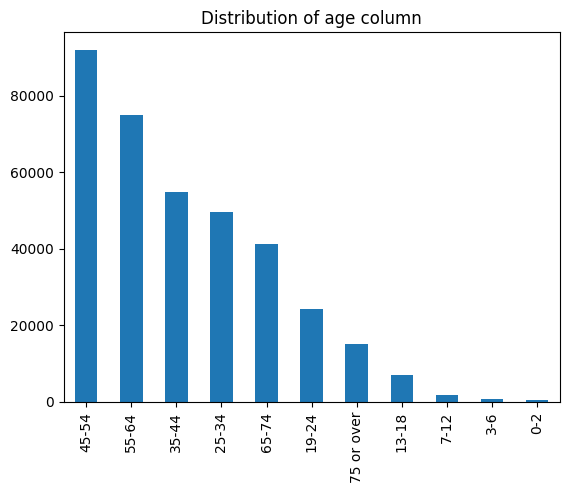

In [ ]:
df.Age.value_counts().plot(kind="bar")
plt.title("Distribution of age column")
plt.show()

In [ ]:
df['Condition'].value_counts()

other                                                         49332
pain                                                          25199
high blood pressure                                           23268
depression                                                    14505
birth control                                                 12251
                                                              ...  
skin & lymph node infection by sporothrix schenckii fungus        1
bacterial blood infection caused by pseudomonas aeruginosa        1
surgery on the thyroid gland                                      1
infection from birth due to toxoplasma gondii parasite            1
disease caused by the worm onchocerca volvulus                    1
Name: Condition, Length: 1805, dtype: int64

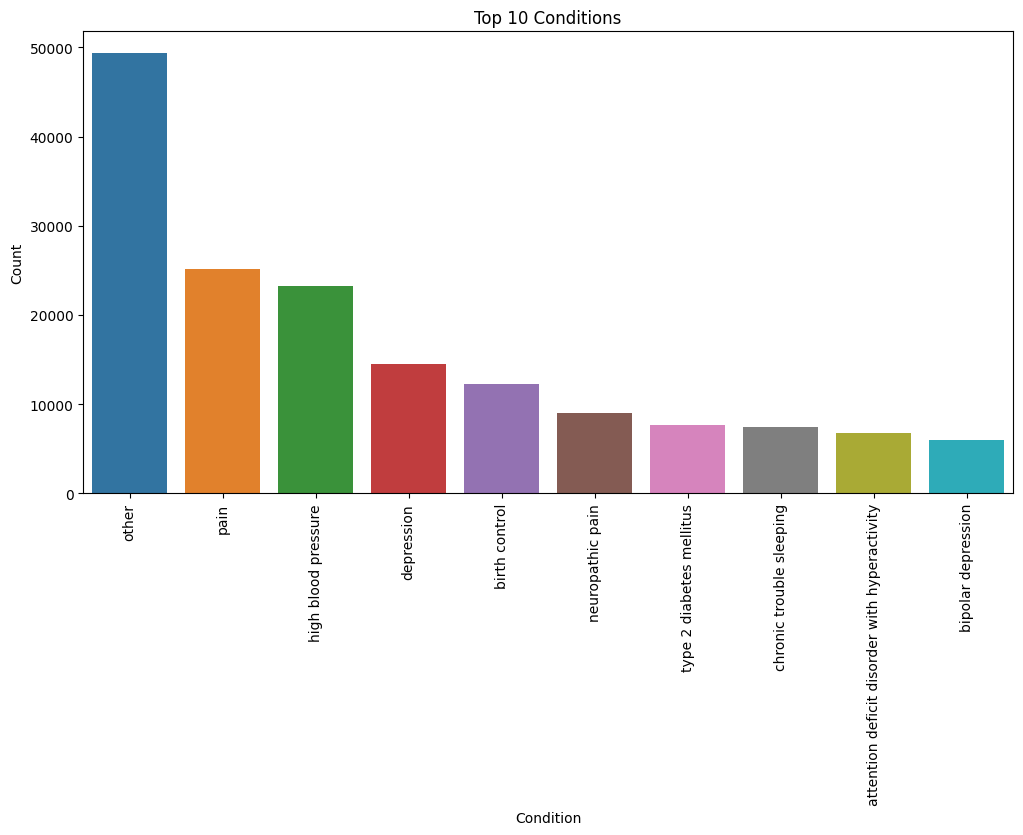

In [ ]:
# Get the top 10 conditions based on frequency counts
top_10_conditions = df['Condition'].value_counts().head(10)

# Plot the top 10 conditions
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_conditions.index, y=top_10_conditions.values)
plt.title('Top 10 Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

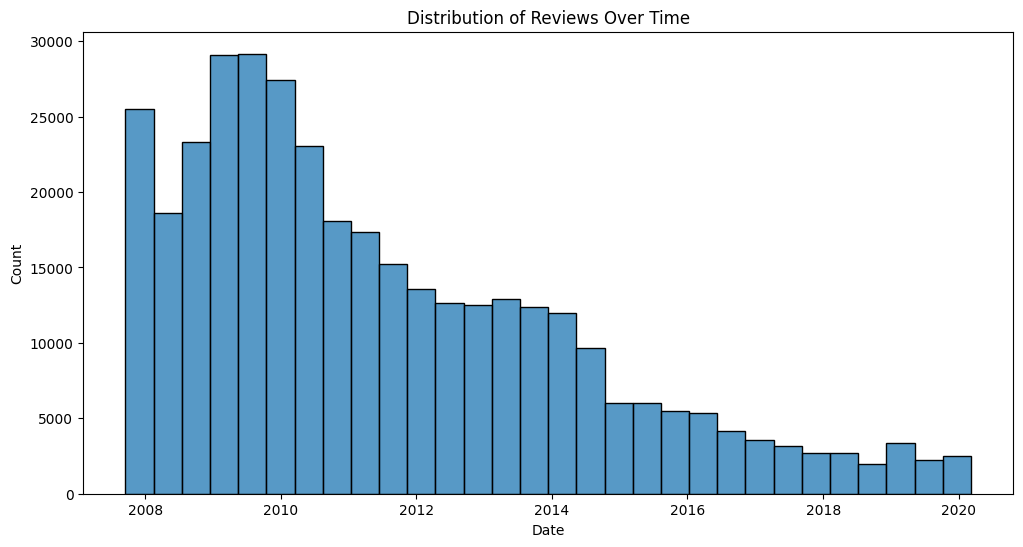

In [ ]:
# Date
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 6))
sns.histplot(df['Date'], bins=30)
plt.title('Distribution of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [ ]:
df.Drug.value_counts()

cymbalta                                                                           4646
lisinopril                                                                         4266
lisinopril solution                                                                4266
lexapro                                                                            4134
hydrocodone-acetaminophen                                                          3943
                                                                                   ... 
ice blue gel 2 % topical dermatological irritants-counter-irritant formulations       1
scalp relief liquid                                                                   1
zidovudine                                                                            1
zolinza                                                                               1
vanadium granules                                                                     1
Name: Drug, Length: 7093, dtype:

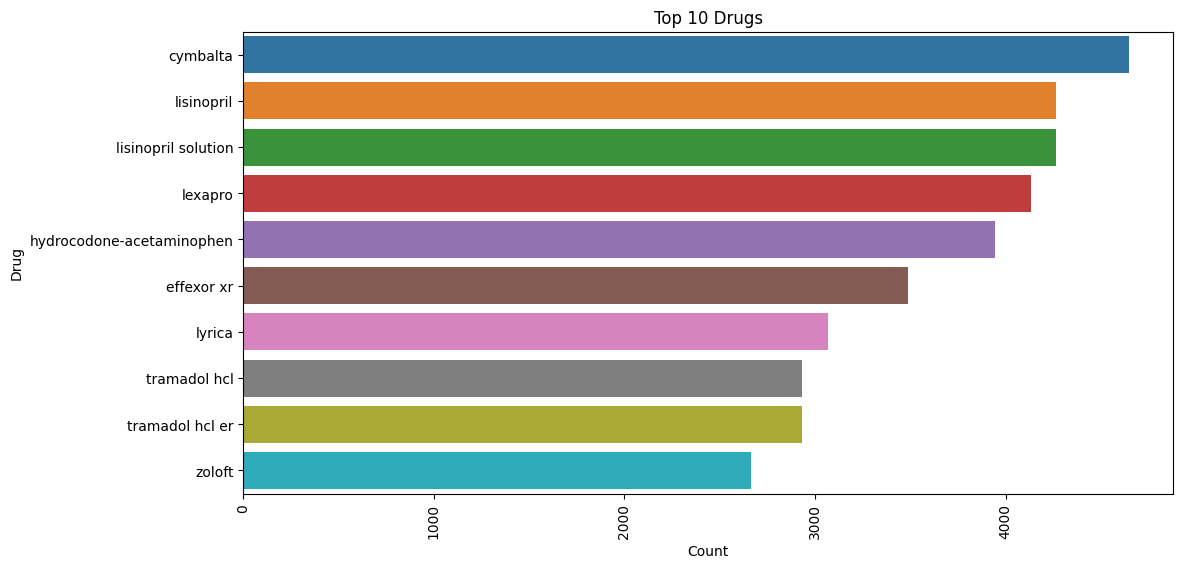

In [ ]:
# Get the top 10 drugs based on frequency counts
top_10_drugs = df['Drug'].value_counts().head(10)

# Plot the top 10 drugs
plt.figure(figsize=(12, 6))
sns.barplot(y=top_10_drugs.index, x=top_10_drugs.values)
plt.title('Top 10 Drugs')
plt.xlabel('Count')
plt.ylabel('Drug')
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(df['EaseofUse'].value_counts())
print(df['Effectiveness'].value_counts())
print(df['Satisfaction'].value_counts())

5     192212
4      74395
3      41166
1      35874
2      18176
6          2
10         1
Name: EaseofUse, dtype: int64
5     130023
4      81660
3      60185
1      59251
2      30704
6          2
10         1
Name: Effectiveness, dtype: int64
5     111164
1     100697
4      63031
3      51784
2      35147
6          2
10         1
Name: Satisfaction, dtype: int64


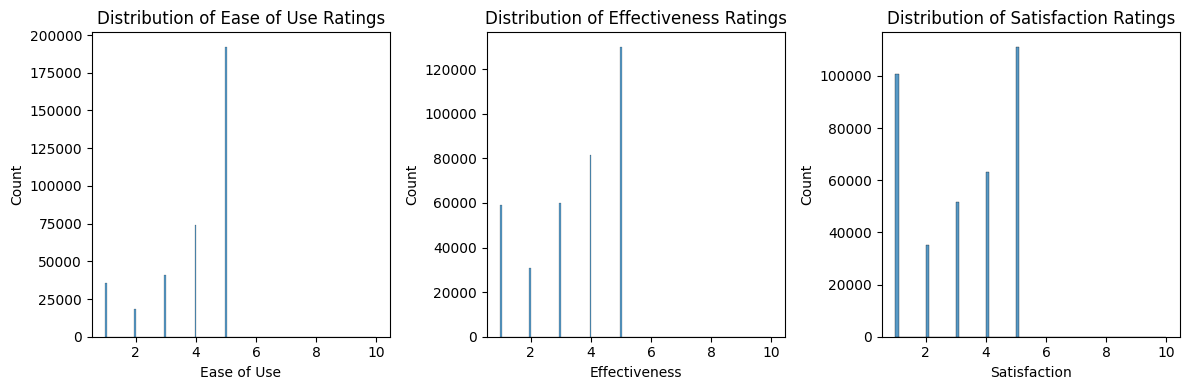

In [ ]:
# EaseofUse, Effectiveness, Satisfaction
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['EaseofUse'])
plt.title('Distribution of Ease of Use Ratings')
plt.xlabel('Ease of Use')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.histplot(df['Effectiveness'])
plt.title('Distribution of Effectiveness Ratings')
plt.xlabel('Effectiveness')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.histplot(df['Satisfaction'])
plt.title('Distribution of Satisfaction Ratings')
plt.xlabel('Satisfaction')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
df['Sex'] = df['Sex'].apply(lambda x: "Female" if x == " " else x)

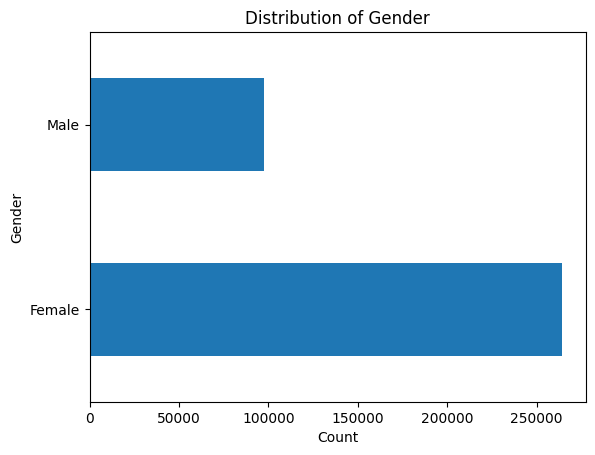

In [ ]:
# Sex
df.Sex.value_counts().plot(kind="barh")
plt.title('Distribution of Gender')
plt.xlabel('Count')
plt.ylabel('Gender')
plt.show()

# Bivariate Analysis

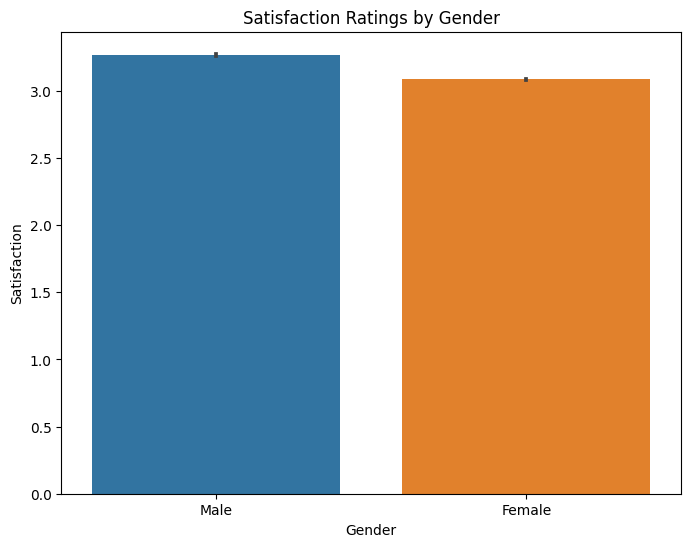

In [ ]:
# Sex vs. Satisfaction
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Sex', y='Satisfaction')
plt.title('Satisfaction Ratings by Gender')
plt.xlabel('Gender')
plt.ylabel('Satisfaction')
plt.show()

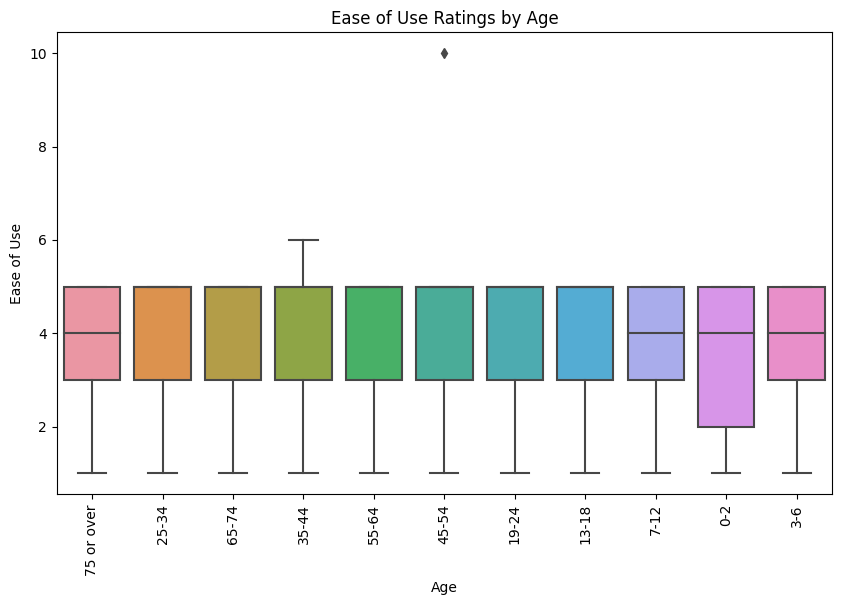

In [ ]:
# Age vs. EaseofUse
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Age', y='EaseofUse')
plt.title('Ease of Use Ratings by Age')
plt.xlabel('Age')
plt.ylabel('Ease of Use')
plt.xticks(rotation=90)
plt.show()

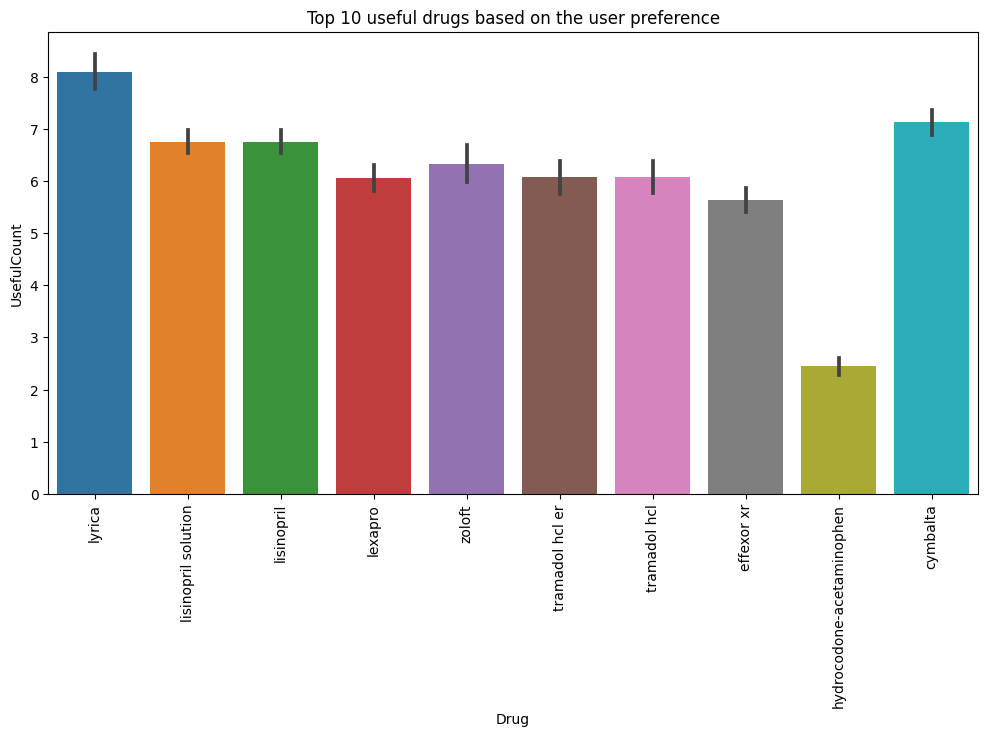

In [ ]:
# Get the top 10 drugs based on frequency counts
top_10_drugs = df['Drug'].value_counts().head(10)

# Filter the data for the top 10 drugs
top_10_data = df[df['Drug'].isin(top_10_drugs.index)]

# Plot the number of users finding reviews useful for the top 10 drugs
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_data, x='Drug', y='UsefulCount')
plt.title('Top 10 useful drugs based on the user preference')
plt.xlabel('Drug')
plt.ylabel('UsefulCount')
plt.xticks(rotation=90)
plt.show()


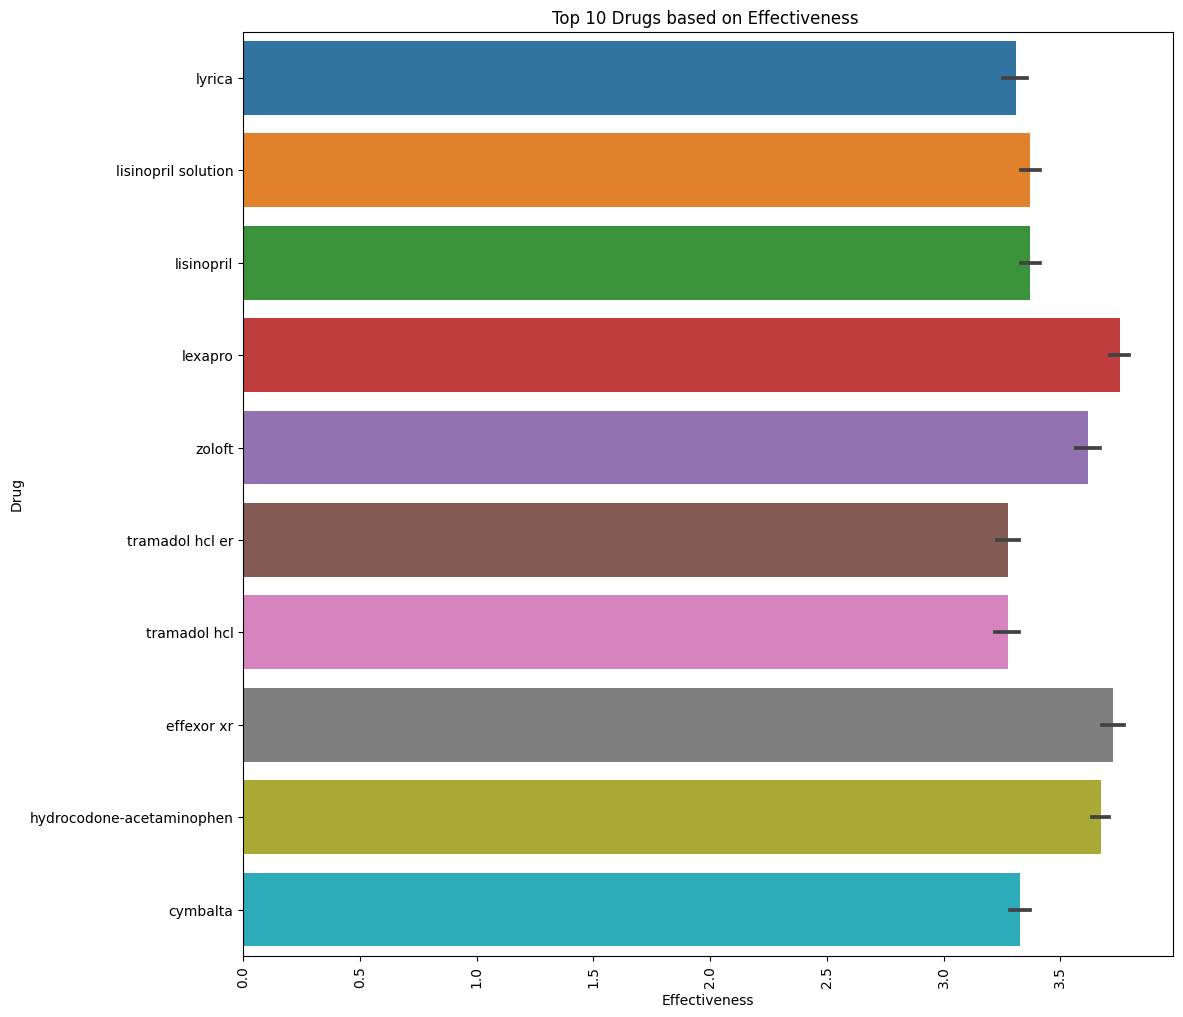

In [ ]:
# Get the top 10 drugs based on frequency counts
top_10_drugs = df['Drug'].value_counts().head(10)

# Filter the data for the top 10 drugs
top_10_data = df[df['Drug'].isin(top_10_drugs.index)]

plt.figure(figsize=(12, 12))
sns.barplot(data=top_10_data, y='Drug', x='Effectiveness')
plt.title('Top 10 Drugs based on Effectiveness ')
plt.xlabel('Effectiveness')
plt.ylabel('Drug')
plt.xticks(rotation=90)
plt.show()

# Multivariate analysis

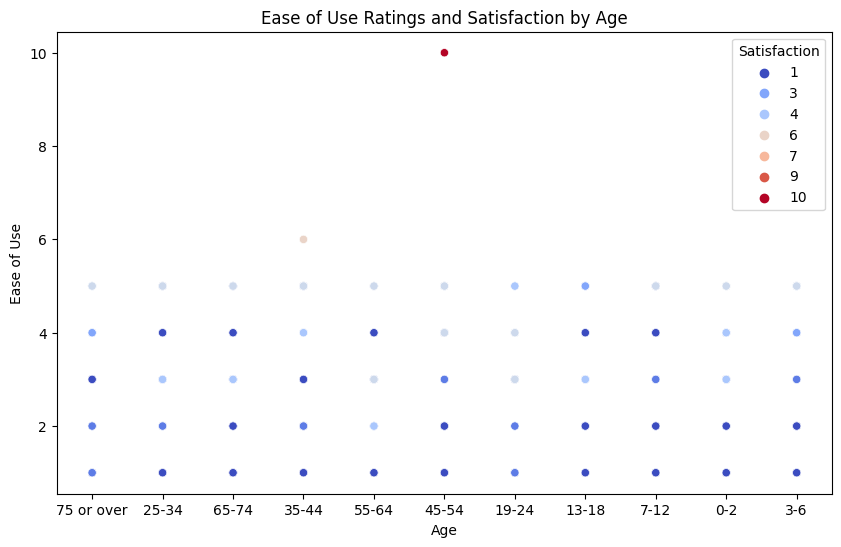

In [ ]:
# Age, EaseofUse, and Satisfaction
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='EaseofUse', hue='Satisfaction', palette='coolwarm')
plt.title('Ease of Use Ratings and Satisfaction by Age')
plt.xlabel('Age')
plt.ylabel('Ease of Use')
plt.show()

<ipython-input-44-e6fc9b41d362>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = drug_sex_satisfaction.pivot('Drug', 'Sex', 'Satisfaction')


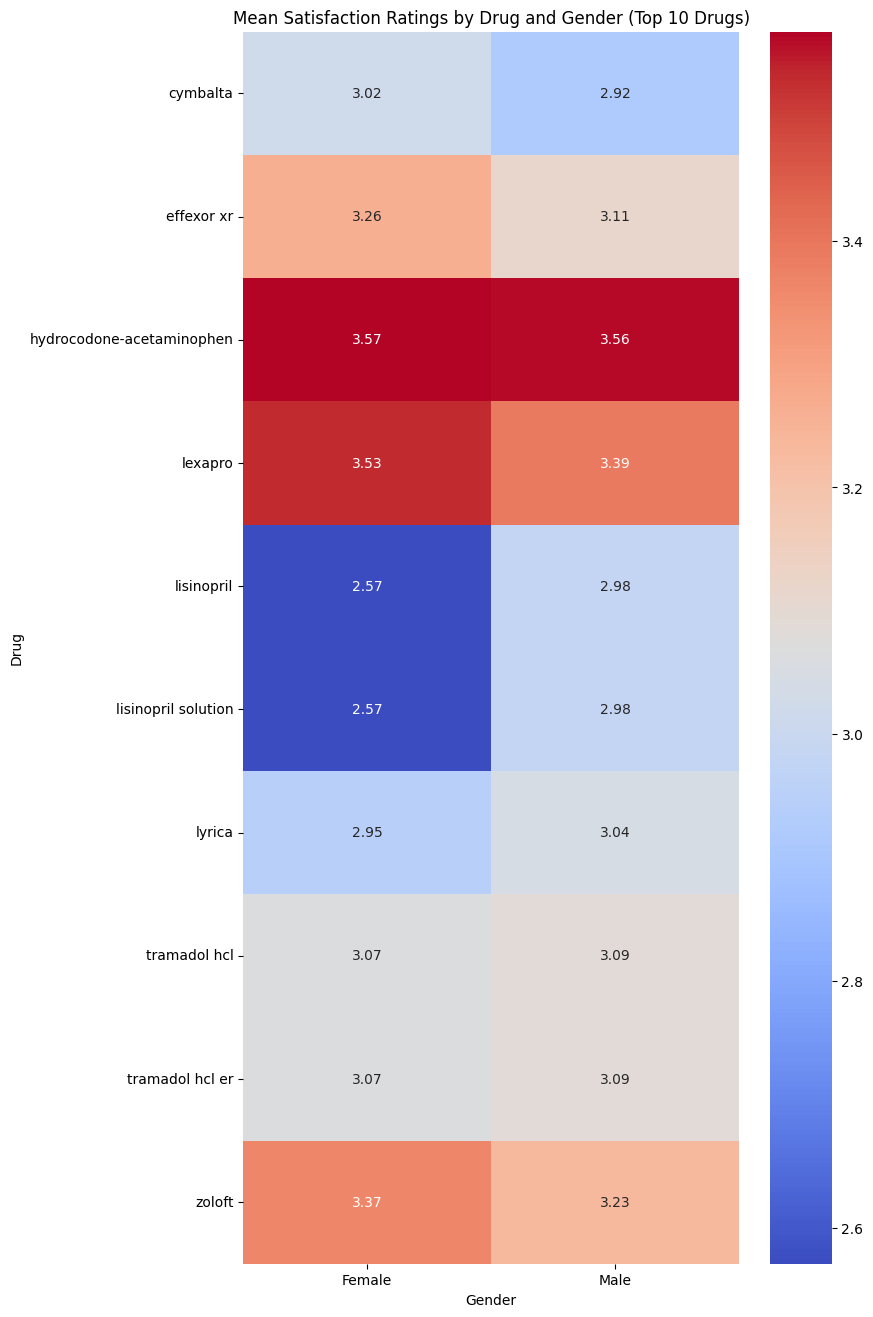

In [ ]:
# Get the top 10 drugs based on frequency counts
top_10_drugs = df['Drug'].value_counts().head(10)

# Filter the data for the top 10 drugs
top_10_data = df[df['Drug'].isin(top_10_drugs.index)]

# Calculate the mean satisfaction ratings by drug and gender
drug_sex_satisfaction = top_10_data.groupby(['Drug', 'Sex'])['Satisfaction'].mean().reset_index()

# Create a pivot table
pivot_table = drug_sex_satisfaction.pivot('Drug', 'Sex', 'Satisfaction')

# Plot the mean satisfaction ratings by drug and gender
plt.figure(figsize=(8, 16))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
plt.title('Mean Satisfaction Ratings by Drug and Gender (Top 10 Drugs)')
plt.xlabel('Gender')
plt.ylabel('Drug')
plt.show()

<ipython-input-33-df8c39b29831>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = condition_age_effectiveness.pivot('Condition', 'Age', 'Effectiveness')


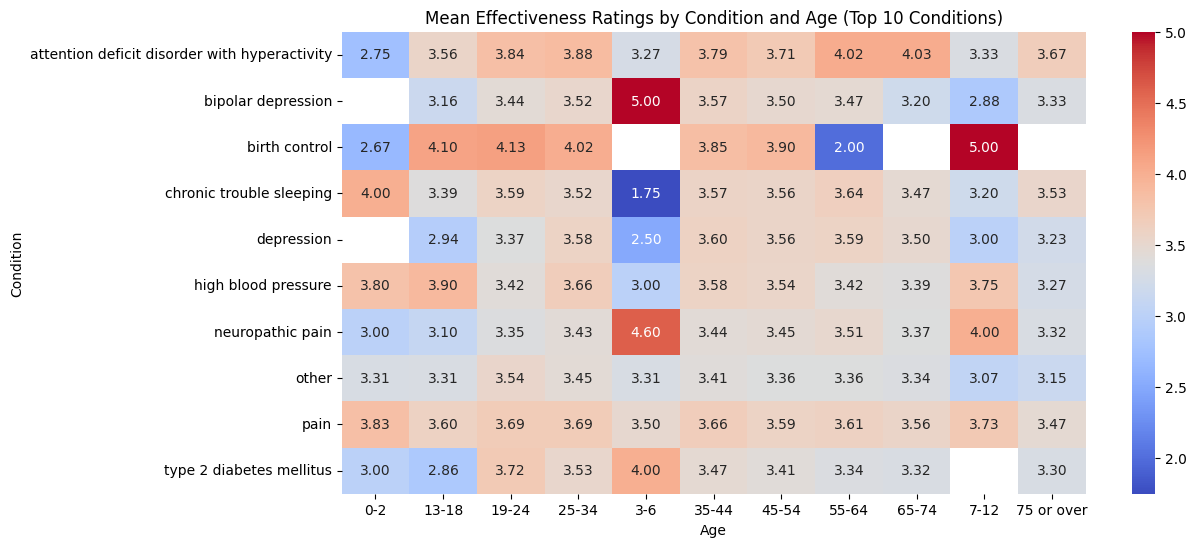

In [ ]:
# Get the top 10 conditions based on frequency counts
top_10_conditions = df['Condition'].value_counts().head(10)

# Filter the data for the top 10 conditions
top_10_data = df[df['Condition'].isin(top_10_conditions.index)]

# Calculate the mean effectiveness ratings by condition and age
condition_age_effectiveness = top_10_data.groupby(['Condition', 'Age'])['Effectiveness'].mean().reset_index()

# Create a pivot table
pivot_table = condition_age_effectiveness.pivot('Condition', 'Age', 'Effectiveness')

# Plot the mean effectiveness ratings by condition and age
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
plt.title('Mean Effectiveness Ratings by Condition and Age (Top 10 Conditions)')
plt.xlabel('Age')
plt.ylabel('Condition')
plt.show()


<ipython-input-34-3762de8cc5ac>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


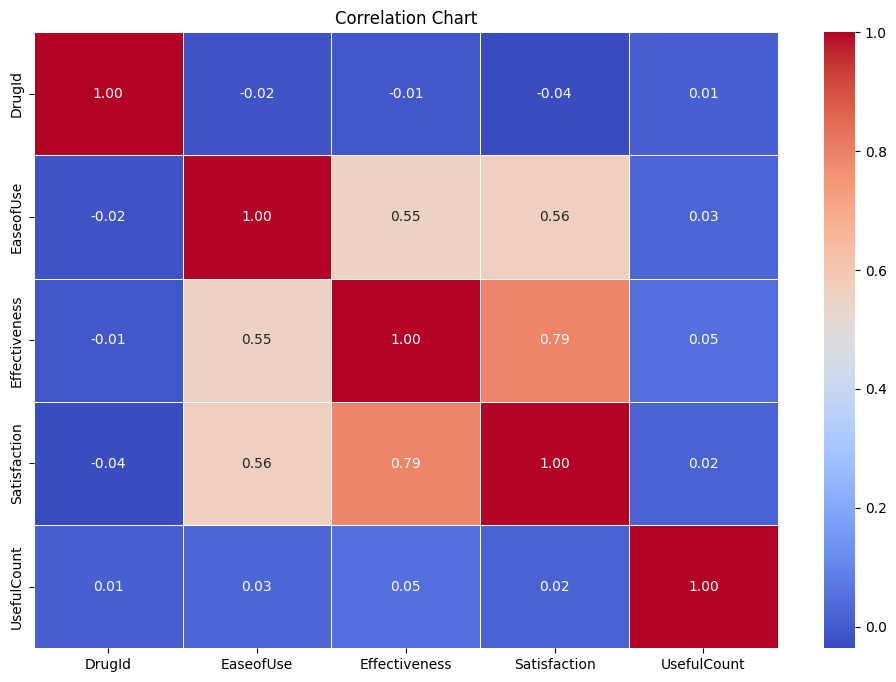

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Chart')
plt.show()


In [ ]:
correlation_matrix

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
DrugId,1.000000,-0.019880,-0.011823,-0.036456,0.011093
EaseofUse,-0.019880,1.000000,0.552331,0.563790,0.028076
Effectiveness,-0.011823,0.552331,1.000000,0.793085,0.047674
Satisfaction,-0.036456,0.563790,0.793085,1.000000,0.018314
UsefulCount,0.011093,0.028076,0.047674,0.018314,1.000000


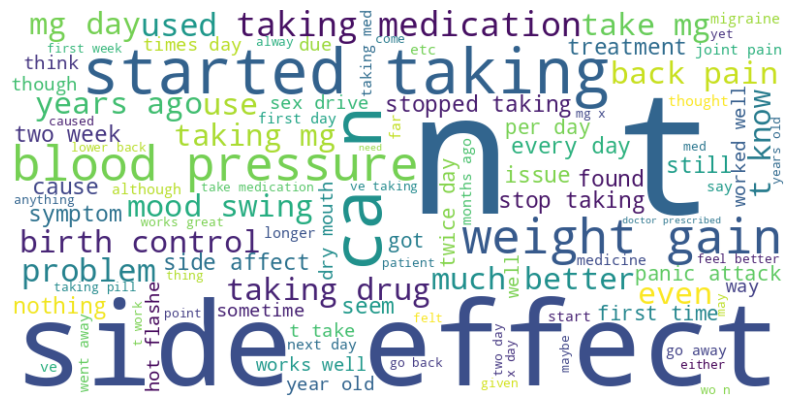

In [ ]:
# Combine all the reviews into a single string
reviews_text = ' '.join(df['Reviews'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(reviews_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
df.to_parquet("data.parquet")

# Collaborative filtering

In [ ]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

In [ ]:
# Prepare the data for collaborative filtering
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(df[['DrugId', 'Condition', 'Effectiveness']], reader)
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

In [ ]:
# Train the collaborative filtering model
model = KNNBasic(k=40, min_k=1, sim_options={'name': 'pearson', 'user_based': False})
model.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
# Generate predictions for the test set
predictions = model.test(testset)

# Extract the true ratings and predicted ratings from the predictions
true_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

In [ ]:
# Generate recommendations for a specific user
user_id = '146724'
n_recommendations = 10

In [ ]:
# Get the drugs that the user hasn't rated
drug_ids = df['DrugId'].unique()
user_ratings = [(drug_id, model.predict(user_id, drug_id).est) for drug_id in drug_ids if drug_id not in df[df['DrugId'] == user_id]['DrugId']]

# Sort the drugs by predicted rating in descending order
user_ratings.sort(key=lambda x: x[1], reverse=True)

# Get the top N recommended drugs
top_recommendations = user_ratings[:n_recommendations]

# Print the top recommendations
print(f'Top {n_recommendations} Drug Recommendations for User {user_id}:')
for rec in top_recommendations:
    drug_id, rating = rec
    drug_name = df.loc[df['DrugId'] == drug_id, 'Drug'].iloc[0]
    print(f'Drug: {drug_name}, Predicted Rating: {rating:.2f}')


Top 10 Drug Recommendations for User 146724:
Drug: 25dph-7.5peh, Predicted Rating: 3.53
Drug: warfarin (bulk) 100 % powder, Predicted Rating: 3.53
Drug: wymzya fe, Predicted Rating: 3.53
Drug: 12 hour nasal relief spray, non-aerosol, Predicted Rating: 3.53
Drug: pyrogallol crystals, Predicted Rating: 3.53
Drug: lyza, Predicted Rating: 3.53
Drug: lysiplex plus liquid, Predicted Rating: 3.53
Drug: lysteda, Predicted Rating: 3.53
Drug: pyrithione zinc shampoo, Predicted Rating: 3.53
Drug: lysine acetate 4,000 mg oral powder packet, Predicted Rating: 3.53


In [ ]:
from surprise import accuracy

# Calculate RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.4184
MAE:  1.1799


In [ ]:
# Take input_symptoms as user input
input_symptoms = input("Enter the symptoms (comma-separated): ").split(',')

# Trim leading/trailing spaces for each symptom
input_symptoms = [symptom.strip() for symptom in input_symptoms]

# Filter the data based on the symptoms
filtered_data = df[df['Condition'].isin(input_symptoms)]

# Get the top recommended drugs based on frequency counts
top_recommended_drugs = filtered_data['Drug'].value_counts().head(10)

# Print the top recommended drugs
print("Top Recommended Drugs for the Symptoms:")
for drug in top_recommended_drugs.index:
    print(drug)


Enter the symptoms (comma-separated): stuffy nose, cold symptoms
Top Recommended Drugs for the Symptoms:
mucinex
mucinex dm
mucinex d tablet, extended release 12 hr
phenylephrine hcl tablet, chewable
oxymetazoline hcl spray, non-aerosol
claritin tablet
mucinex d
sudafed
claritin-d 24 hour
capmist dm


# Weighted hybrid recommendation algorithm

In [ ]:
df1=pd.read_parquet("data.parquet")
df1.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,stuffy nose,2014-09-21,25dph-7.5peh,146724,5,5,m retired physician meds tried allergies se...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,cold symptoms,2011-01-13,25dph-7.5peh,146724,5,5,cleared right even throat hurting went away ta...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,other,2012-07-16,warfarin (bulk) 100 % powder,144731,2,3,ptinr go normal,3,Female,,0
3,75 or over,other,2010-09-23,warfarin (bulk) 100 % powder,144731,2,2,falling n t realise,1,Female,,0
4,35-44,other,2009-01-06,warfarin (bulk) 100 % powder,144731,1,1,grandfather prescribed medication coumadin ...,1,Male,,1


In [ ]:
data=df1.head(10000)


In [ ]:
data.columns

Index(['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse',
       'Effectiveness', 'Reviews', 'Satisfaction', 'Sex', 'Sides',
       'UsefulCount'],
      dtype='object')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
# Prepare the data for collaborative filtering
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(data[['DrugId', 'Condition', 'Effectiveness']], reader)

trainset, testset = train_test_split(data_surprise, test_size=0.2)

# Train the collaborative filtering model
model_collab = KNNBasic(k=40, min_k=1, sim_options={'name': 'pearson', 'user_based': False})
model_collab.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
# Content-Based Filtering

# Prepare the data for content-based filtering
data_content = data[['DrugId', 'Drug', 'Condition', 'Reviews']]
data_content['Review'] = data_content['Reviews'].fillna('')  # Replace NaN values with empty string

# Create TF-IDF vectors for the drug reviews
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data_content['Reviews'])

# Calculate pairwise cosine similarity between the TF-IDF vectors
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

<ipython-input-92-f5841bc56b5e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_content['Review'] = data_content['Reviews'].fillna('')  # Replace NaN values with empty string


In [ ]:
# Generate recommendations for a specific user
user_id = '146724'
n_recommendations = 10

# Get the drugs that the user hasn't rated
user_rated_drugs = data[data['DrugId'] == user_id]['Drug']
unrated_drugs = data_content[~data_content['Drug'].isin(user_rated_drugs)]['Drug']
drug_indices = data_content[data_content['Drug'].isin(unrated_drugs)].index


In [ ]:
# Calculate the weighted ratings based on collaborative filtering and content-based filtering
weighted_ratings = []
for idx in drug_indices:
    drug_id = data_content.loc[idx, 'DrugId']
    collab_rating = model_collab.predict(user_id, drug_id).est
    content_rating = sum(cosine_sim[idx, drug_indices] * data['Effectiveness'].values[drug_indices]) / sum(cosine_sim[idx, drug_indices])
    weighted_rating = 0.6 * collab_rating + 0.4 * content_rating  # Adjust the weights according to your preference
    weighted_ratings.append((drug_id, weighted_rating))

# Sort the drugs by weighted rating in descending order
weighted_ratings.sort(key=lambda x: x[1], reverse=True)

# Get the top N recommended drugs
top_recommendations = weighted_ratings[:n_recommendations]

<ipython-input-94-9b501080d79b>:6: RuntimeWarning: invalid value encountered in double_scalars
  content_rating = sum(cosine_sim[idx, drug_indices] * data['Effectiveness'].values[drug_indices]) / sum(cosine_sim[idx, drug_indices])


In [ ]:
# Print the top recommendations
print(f'Top {n_recommendations} Drug Recommendations for User {user_id}:')
for rec in top_recommendations:
    drug_id, rating = rec
    drug_name = data.loc[data['DrugId'] == drug_id, 'Drug'].iloc[0]
    print(f'Drug: {drug_name}, Weighted Rating: {rating:.2f}')

Top 10 Drug Recommendations for User 146724:
Drug: wymzya fe, Weighted Rating: nan
Drug: loratadine-d, Weighted Rating: 3.67
Drug: pyrogallol crystals, Weighted Rating: 3.67
Drug: 12 hour nasal relief spray, non-aerosol, Weighted Rating: 3.62
Drug: warfarin (bulk) 100 % powder, Weighted Rating: 3.62
Drug: lysteda, Weighted Rating: 3.61
Drug: lysteda, Weighted Rating: 3.58
Drug: lysteda, Weighted Rating: 3.58
Drug: lysteda, Weighted Rating: 3.57
Drug: lysteda, Weighted Rating: 3.57


In [ ]:
# Calculate the predicted ratings for the test set using the hybrid recommendation system
predicted_ratings = []
for test_data in testset:
    user_id = test_data[0]
    drug_id = test_data[1]

    # Calculate the weighted rating for the drug
    collab_rating = model_collab.predict(user_id, drug_id).est
    content_rating = sum(cosine_sim[drug_indices, drug_indices] * data['Effectiveness'].values[drug_indices]) / sum(cosine_sim[drug_indices, drug_indices])
    weighted_rating = 0.6 * collab_rating + 0.4 * content_rating

    predicted_ratings.append(weighted_rating)

# Extract the actual ratings from the test set
actual_ratings = [test_data[2] for test_data in testset]

# Calculate RMSE and MAE
rmse = mean_squared_error(actual_ratings, predicted_ratings, squared=False)
mae = mean_absolute_error(actual_ratings, predicted_ratings)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 1.42
MAE: 1.22


In [ ]:
# Take input_symptoms as user input
input_symptoms = input("Enter the symptoms (comma-separated): ").split(',')

# Trim leading/trailing spaces for each symptom
input_symptoms = [symptom.strip() for symptom in input_symptoms]

# Filter the data based on the symptoms
filtered_data = data[data['Condition'].isin(input_symptoms)]

# Get the top recommended drugs based on frequency counts
top_recommended_drugs = filtered_data['Drug'].value_counts().head(10)

# Print the top recommended drugs
print("Top Recommended Drugs for the Symptoms:")
for drug in top_recommended_drugs.index:
    print(drug)

Enter the symptoms (comma-separated): birth control
Top Recommended Drugs for the Symptoms:
lo loestrin fe
loryna
low-ogestrel
loseasonique
loestrin fe
lomedia 24 fe
lyza
loestrin
loestrin fe tablet
loestrin tablet


# Code references

* Hug, N. (no date) Surprise, Surprise. Available at: https://surpriselib.com/.

* Vu, D. (2019) Python Word Clouds Tutorial: How to Create a Word Cloud, Datacamp.com. DataCamp. Available at: https://www.datacamp.com/tutorial/wordcloud-python.

* Deepanshi (2021) Text Preprocessing in NLP with Python Codes, Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/.


